# YAASS Dataset

#### The dataset below includes demographic information and multiple clinical measures taken in 3 populations: healthy controls, those at clinical high risk for psychosis, and those at familial high risk.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/YAASS/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'

In [2]:
%cd {path2code}

import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) #helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # useful for getting effect sizes from chi-square tests

/Users/ebarrick/Work/Expts/Code


array(['vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex', 'reshape2',
       'effsize', 'lsmeans', 'estimability', 'lmerTest', 'lme4', 'Matrix',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='|S12')

In [13]:
raw_sh = pd.read_excel(path2data + 'Bx_Paper_YAASS_Feb2017.xlsx')
raw_sh['Gender'].replace(2, 'female', inplace=True)
raw_sh['Gender'].replace(1,'male', inplace=True)

raw_sz = pd.read_excel(path2data + 'SCORE_Final Sample_2.xlsx')
raw_sz['Group'].replace(2, 'SZ', inplace=True)
raw_sz['Group'].replace(1,'HC', inplace=True)

raw_fhr = pd.read_excel(path2data + 'FAME_Neuropsych_NEW_2.xlsx')
raw_fhr['Group'].replace(1, 'FHR', inplace=True)
raw_fhr['Gender'].replace(2, 'female', inplace=True)
raw_fhr['Gender'].replace(1,'male', inplace=True)

g = raw_sh.append(raw_sz)

raw = g.append(raw_fhr)
pd.set_option('display.max_columns', 500)
raw

,Age,BDI,COWAT_Animal,DSMDisorder,DSMDisorderType,DSMcomorbidities,DepAnx_PANSS,Digit_Symbol_Scaled,Disorganized_PANSS,Education,Emot_IQ,Emotion_Experiencing,Emotional_reasoning,Ethnicity,Excited_PANSS,GFS_Role,GFS_Social,Gender,Group,HVLT_Tscore_Trials,ID,IQ,IRI_EC,IRI_FS,IRI_PD,IRI_PT,IRI_Total,Letter_Num_Seq_Scaled,Magical_ideation,Managing_emotions,Medication,Negative_PANSS,Other_PANSS,PAS,Perceiving_EmotionsSSB1,Physical_anhedonia,Positive_PANSS,Referential_thinking,SAS,SIPS_Disorganized,SIPS_General,SIPS_Negative,SIPS_Positive,SS_B,SS_C,SS_D,SS_E,SS_F,SS_G,SS_H,SS_a,STAI_state,STAI_trait,SocAdjScale_SocialLeisure,SocAdjScale_Work,SocAdjScale_WorkRole,TotalPLE,TrailsA_Tscore,TrailsB_Tscore,Understanding_emotions,Using_emotionsSSB2,Yrs of Education,log_Emot_IQ,log_Emotion_Experiencing,log_Emotional_reasoning,log_GFS_Role,log_GFS_Social,log_IRI_EC,log_IRI_FS,log_IRI_PD,log_IRI_PT,log_IRI_Total,log_Managing_emotions,log_SAS_SocialLeisure,log_SAS_Work,log_Understanding_emotions
0,33,NaN,18,NaN,NaN,NaN,4,NaN,5,12,NaN,NaN,NaN,NaN,4,NaN,NaN,female,HC,39,26105,102,36,30,12,32,110,NaN,NaN,NaN,NaN,7,10,NaN,NaN,NaN,5,NaN,NaN,0.00,0.00,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,80,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.556303,1.477121,1.079181,1.505150,2.041393,NaN,1.690196,1.903090,NaN
1,22,NaN,37,NaN,NaN,NaN,4,15,5,16,111.605097,106.704198,111.004276,NaN,4,9,10,male,HC,48,26120,133,24,33,14,31,102,18,NaN,106.421008,NaN,7,10,NaN,100.104756,NaN,5,NaN,NaN,0.00,0.00,2.000000,1.0,124.993787,109.684629,104.351949,111.300239,96.811400,102.900197,104.732502,92.275573,NaN,NaN,42.0,0,NaN,0,43,72,108.092162,111.993224,NaN,2.047684,2.028182,2.045340,0.954243,1.000000,1.380211,1.518514,1.146128,1.491362,2.008600,2.027027,1.623249,NaN,2.033794
2,19,NaN,17,NaN,NaN,NaN,4,16,5,14,98.740000,90.430000,109.250000,NaN,4,9,10,female,HC,NaN,26130,118,NaN,NaN,NaN,NaN,NaN,12,NaN,101.560000,NaN,7,10,NaN,100.290000,NaN,5,NaN,NaN,0.00,0.00,0.000000,0.0,76.946287,110.152912,99.318697,87.280961,87.878911,108.458863,101.373239,142.935444,NaN,NaN,45.0,51,NaN,0,NaN,NaN,111.890000,80.410000,NaN,1.994493,1.956313,2.038421,0.954243,1.000000,NaN,NaN,NaN,NaN,NaN,2.006723,1.653213,1.707570,2.048791
3,24,NaN,29,NaN,NaN,NaN,4,NaN,5,17,101.930000,102.170000,98.220000,NaN,4,9,10,female,HC,65,26133,103,34,34,16,33,117,12,NaN,92.390000,NaN,7,10,NaN,112.490000,NaN,6,NaN,NaN,2.00,2.00,1.000000,4.0,83.040486,97.818194,94.128201,109.019677,101.526393,112.078773,90.910849,110.362848,NaN,NaN,62.0,55,NaN,0,68,51,106.800000,89.910000,NaN,2.008302,2.009323,1.992200,0.954243,1.000000,1.531479,1.531479,1.204120,1.518514,2.068186,1.965625,1.792392,1.740363,2.028571
4,19,NaN,NaN,NaN,NaN,NaN,4,NaN,5,13,108.700000,120.120000,95.810000,NaN,4,9,9,male,HC,NaN,26137,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.490000,NaN,7,10,NaN,131.930000,NaN,5,NaN,NaN,0.00,0.00,0.000000,0.0,119.176320,101.728865,91.471298,111.905737,94.864296,92.002647,98.220674,142.935444,NaN,NaN,45.0,NaN,NaN,0,NaN,NaN,95.710000,106.870000,NaN,2.036230,2.079615,1.981411,0.954243,0.954243,NaN,NaN,NaN,NaN,NaN,1.979958,1.653213,NaN,1.980957
5,28,NaN,19,NaN,NaN,NaN,4,6,5,18,96.030000,84.930000,113.180000,NaN,5,10,10,male,HC,42,26138,123,39,31,9,40,119,10,NaN,108.440000,NaN,7,10,NaN,82.740000,NaN,5,NaN,NaN,0.00,0.00,0.000000,0.0,101.397049,102.617500,105.178980,110.159696,88.610963,112.078773,106.711408,62.488205,NaN,NaN,51.0,48,NaN,0,36,35,109.330000,93.020000,NaN,1.982407,1.929061,2.053770,1.000000,1.000000,1.591065,1.491362,0.954243,1.602060,2.075547,2.035190,1.707570,1.681241,2.038739
6,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male,HC,NaN,26172,115,30,29,20,25,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.477121,1.462398,1.301030,1.397940,2.017033,NaN,NaN,NaN,NaN
7,20,NaN,27,NaN,NaN,NaN,4,19,5,15,108.716897,105.694031,106.294636,NaN,4,10,10,male,HC,46,26173,138,3

### FAME dataset

In [45]:
def dx_name(data):
    d = {0:'None', 1:'MDD', 2:'Anxiety', 3:'Sub_abuse', 4:'ADHD', 
         5:'Eating', 6:'Schizotypal', 7:'2_co', 8: '3_co', 9:'4_co'}
    dx = d[data]
    return dx    

In [46]:
fhr['DSMDisorderType'] = fhr.DSMDisorderType.apply(dx_name)

/Users/ebarrick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [47]:
fhr.head()

,ID,Group,Gender,Age,Education,IQ,DSMDisorder,DSMDisorderType,DSMcomorbidities,Medication,BDI,STAI_state,STAI_trait,Referential_thinking,PAS,Magical_ideation,SAS,Physical_anhedonia,SocAdjScale_WorkRole,SocAdjScale_SocialLeisure,SIPS_Positive,SIPS_Negative,SIPS_Disorganized,SIPS_General,IRI_PT,IRI_EC,IRI_FS,IRI_PD
0,2501,FHR,female,25,14,99,1,2_co,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4,0.500000,0.75,0.75,NaN,NaN,NaN,NaN
1,2504,FHR,female,29,16,118,1,2_co,2,1,0,21,25,1,1,7,2,5,1.5,1.2,1.0,0.333333,0.50,0.50,23,21,6,6
2,2505,FHR,male,33,14,95,0,None,0,0,0,20,20,0,1,1,11,2,1.5,1.9,0.4,0.000000,0.25,0.00,24,21,19,5
3,2506,FHR,male,33,13,109,1,ADHD,1,0,3,35,36,5,9,4,24,11,1.4,1.8,1.2,1.166667,1.00,0.75,23,14,15,9
5,2509,FHR,female,25,17,121,1,Anxiety,1,0,0,21,24,0,1,2,2,14,1.3,1.7,0.4,0.666667,0.50,0.00,15,26,18,11


### Demographics

In [14]:
raw.groupby('Group')['ID'].nunique()

Group
FHR    19
HC     47
HR     27
SZ     24
Name: ID, dtype: int64

In [15]:
"""Even split in HC group, more males in HR and SZ group - unsurprising...however mostly 
female in GHR group."""

raw.groupby('Group')['Gender'].value_counts()

Group        
FHR    female    14
       male       5
HC     male      26
       female    21
HR     male      18
       female     9
SZ     male      15
       female     9
dtype: int64

Group       
FHR    count    19.000000
       mean     27.421053
       std       3.920258
       min      20.000000
       25%      24.500000
       50%      27.000000
       75%      31.000000
       max      33.000000
HC     count    47.000000
       mean     28.872340
       std      10.884007
       min      18.000000
       25%      21.000000
       50%      24.000000
       75%      33.000000
       max      55.000000
HR     count    27.000000
       mean     21.629630
       std       4.404090
       min      15.000000
       25%      18.000000
       50%      22.000000
       75%      23.500000
       max      34.000000
SZ     count    24.000000
       mean     39.500000
       std      11.263639
       min      21.000000
       25%      30.750000
       50%      39.500000
       75%      45.000000
       max      64.000000
dtype: float64


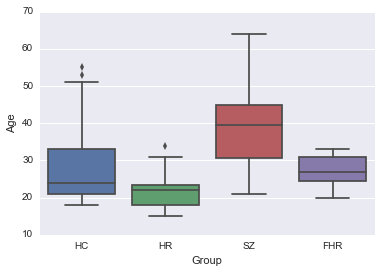

In [16]:
#Age
g=raw.groupby('Group')
print (g.Age.describe())

sns.boxplot(x='Group',y='Age',data=raw)

In [17]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

Group       
FHR    count     18.000000
       mean     117.000000
       std        9.779931
       min       95.000000
       25%      115.500000
       50%      118.000000
       75%      121.750000
       max      136.000000
HC     count     47.000000
       mean     111.595745
       std       10.999327
       min       89.000000
       25%      103.500000
       50%      113.000000
       75%      118.000000
       max      138.000000
HR     count     24.000000
       mean     106.791667
       std       17.688068
       min       79.000000
       25%       91.750000
       50%      106.500000
       75%      122.250000
       max      139.000000
SZ     count     24.000000
       mean     107.041667
       std       15.685715
       min       70.000000
       25%       99.000000
       50%      108.000000
       75%      118.250000
       max      140.000000
dtype: float64
Between group t-test on IQ HC and HR
t(69) = 1.41, p = 0.164
Between group t-test on IQ HC and SZ
t(69) = 1.

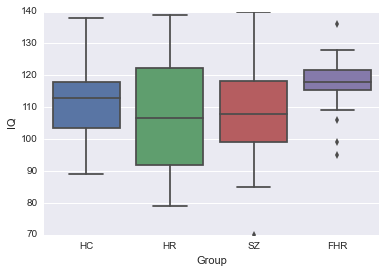

In [23]:
#IQ: Looks like FHR has significantly higher IQ than HC (and therefore all groups)

i = raw_IQ.groupby('Group')

print (i.IQ.describe())
print ('Between group t-test on IQ HC and HR')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'HR']['IQ'])

print ('Between group t-test on IQ HC and SZ')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'SZ']['IQ'])

print ('Between group t-test on IQ HC and FHR')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'FHR']['IQ'])

sns.boxplot(x='Group',y='IQ',data=raw_IQ)

### Data Quality Check

In [19]:
"""Dataframe where any row that has NAN value is dropped- will tell us how many participants 
have at least some missing data"""
sh_no_na = raw_sh.dropna()

In [20]:
# looks like most participants have some missing values...
sh_no_na.groupby('Group')['ID'].nunique()

Group
HC    8
HR    9
Name: ID, dtype: int64

In [21]:
"""Dataframe where any row that has less than 6 entries - which corresponds to anything other 
than demographic information/subject ID entered - are dropped. These are participants that 
should not be included in the analyses."""
df_cleaned = raw.dropna(thresh=6)

In [24]:
#one participant that has no measures taken: 26195
df_cleaned.groupby('Group')['ID'].nunique()

Group
FHR    19
HC     47
HR     26
SZ     24
Name: ID, dtype: int64